# Comparing iXnos results to Sahim's averaged dwell time predictions
As an alternative to using iXnos, Sahim counted the average counts of ribosomes wrt the codon in the A site alone, and used that to predict elongation times. Here, I'm comparing the results of that to those from my retrained Iwasaki iXnos models

In [40]:
import sys
import os
sys.path.append("src/")
from src import *
sys.path.append("scripts/")
from ixnos import iXnos
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from Bio import SeqIO
import seaborn as sns
import random

# Load model(s)
iwasaki_n3p2 = iXnos(min_codon=-3, max_codon=2)
iwasaki_n3p2.load_state_dict(torch.load("processed-data/iwasaki/models/ixnos_n3p2_full.pth", weights_only=False))
iwasaki_n3p2.eval()

iwasaki_n5p4 = iXnos(min_codon=-5, max_codon=4)
iwasaki_n5p4.load_state_dict(torch.load("models/ixnos_retrained.pth"))
iwasaki_n5p4.eval() 
# Load dwell times
dt = pd.read_csv("processed-data/Iwasaki_compiled_dwelltimes.tsv", sep=r"\s+", index_col=0)
dt = dict(dt.reset_index().values)
# Citrine sequence
cit_seq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLGYGLMCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

/tmp/ipykernel_10643/1113653344.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  iwasaki_n5p4.load_state_dict(torch.load("models/ixnos_retrained.pth"))


In [ ]:
seqs_n3p2, speeds_n3p2 = iwasaki_n3p2.predict_random_speeds(cit_seq, 10_000)
seqs_n5p4, speeds_n5p4 = iwasaki_n5p4.predict_random_speeds(cit_seq, 10_000)
# 2m30 for 1k seqs
# 22m9s for 10,000 seqs

In [42]:
dt_speeds_n3p2 = [sum([dt[seq[i:i+3]] for i in range(0, len(seq), 3)]) for seq in seqs_n3p2]
dt_speeds_n5p4 = [sum([dt[seq[i:i+3]] for i in range(0, len(seq), 3)]) for seq in seqs_n5p4]

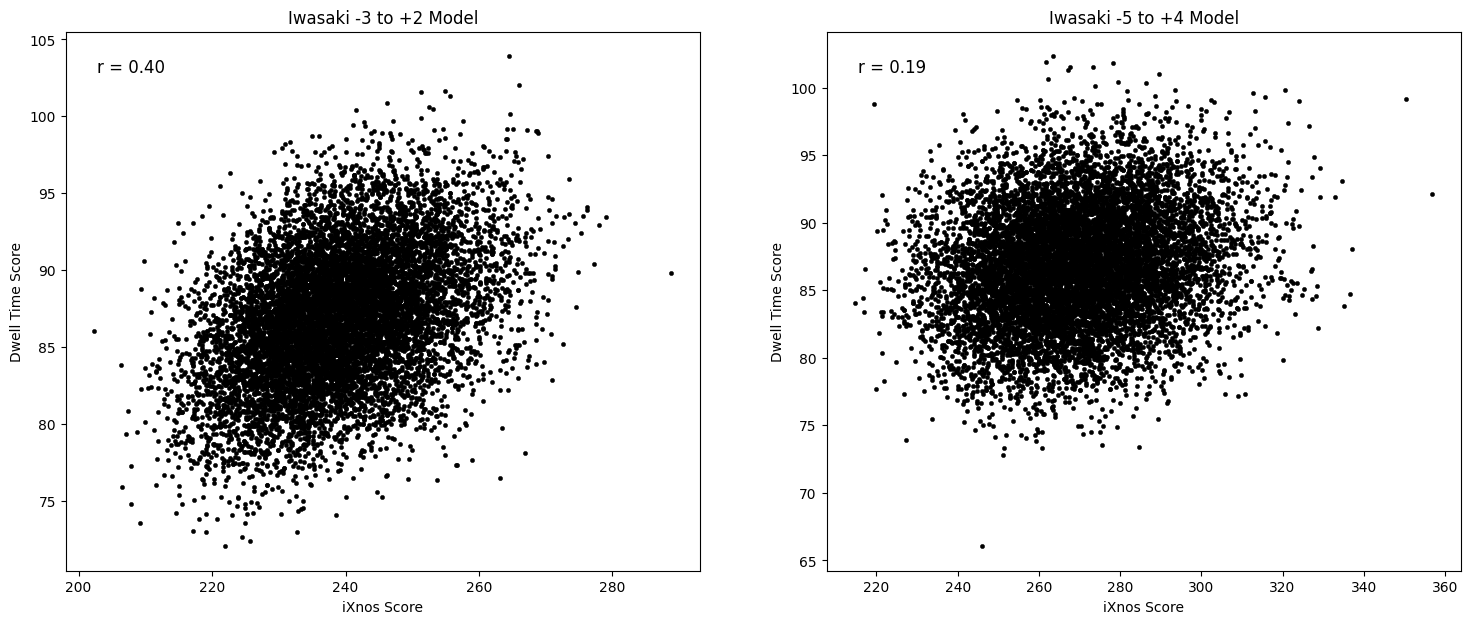

In [47]:
def scatter(df, x, y, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    sns.scatterplot(
        df,
        x = x,
        y = y, 
        # hue = hue,
        ax=ax,
        **kwargs
    )
    r = df[x].corr(df[y], method="pearson")
    # ax.legend(title="sequence class", **legend_kwargs())
    ax.text(0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.65))
    return ax


fig, axs = plt.subplots(1, 2, figsize=(18, 7))
df_n3p2 = pd.DataFrame({
    "iXnos Score": speeds_n3p2,
    "Dwell Time Score": dt_speeds_n3p2,
})
scatter(df_n3p2, x="iXnos Score", y="Dwell Time Score", edgecolor=None, c='k', s=10, ax=axs[0])
axs[0].set_title("Iwasaki -3 to +2 Model")
# plt.show()

df_n5p4 = pd.DataFrame({
    "iXnos Score": speeds_n5p4,
    "Dwell Time Score": dt_speeds_n5p4,
})
scatter(df_n5p4, x="iXnos Score", y="Dwell Time Score", edgecolor=None, c='k', s=10, ax=axs[1])
axs[1].set_title("Iwasaki -5 to +4 Model")
plt.show()